# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [52]:
import matplotlib.pyplot as plt

### Download and Prepare CIFAR-10

We use `transform_imagenet` (resize to 224x224 + ImageNet normalization) because the pretrained models expect inputs in the same format they were trained on. CIFAR-10 images are only 32x32, so `T.Resize(224)` upscales them to match ImageNet's expected input size. The normalization values (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) are the standard ImageNet channel statistics.

In [53]:
DATA_PATH = '/Users/oliverperez/Documents/Tec/MNA/Advanced Machine Learning/DB'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [54]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### GPU Setup

Transfer learning models are large — running them on CPU would be very slow. We use MPS (Apple Silicon) or CUDA (NVIDIA) when available.

In [55]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')  # Use Apple Silicon GPU!
else:
    device = torch.device('cpu')

print(device)

mps


### Visualize Sample Images

La imagen muestreada representa un: Plane


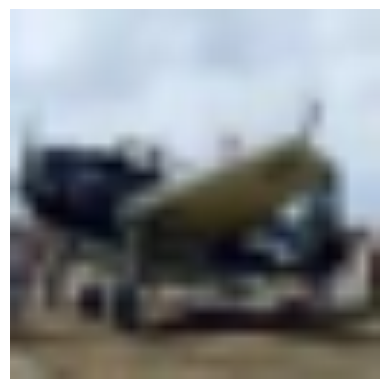

In [56]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Accuracy Function

In [57]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   



---

## Model 1: ResNet-18 Transfer Learning (provided solution)

ResNet-18 is a relatively small residual network (~11M params) that uses skip connections to enable training of deeper architectures. We load the pretrained ImageNet weights, strip the final FC layer (which maps 512 features to 1000 ImageNet classes), freeze the backbone, and add a new `Linear(512, 10)` layer for CIFAR-10.

In [58]:
# Load ResNet-18 with pretrained ImageNet weights (modern API)
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

#### Explore the model parameters

In [59]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [60]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Adapt the model for CIFAR-10

Strip the last layer (FC 512->1000), freeze all pretrained weights, and add a new classification head for 10 classes.

In [61]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [62]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [63]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [64]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [65]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Training Loop

Standard PyTorch training loop. We track average cost, training accuracy, and validation accuracy per epoch. Since we froze the pretrained backbone, only the new linear head's parameters have gradients — so training is fast.

In [66]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        model.train()
        train_cost_acum = 0
        train_correct = 0
        train_total = 0
        for i, (xi, yi) in enumerate(train_loader):
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input=scores, target=yi)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            train_cost_acum += cost.item()
            train_correct += (torch.argmax(scores, dim=1) == yi).sum().item()
            train_total += yi.size(0)

        val_acc = accuracy(model, val_loader)
        train_acc = train_correct / train_total
        train_cost = train_cost_acum / (i + 1)
        print(f'Epoch: {epoch}, train cost: {train_cost:.4f}, '
              f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f}')

In [67]:
hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [68]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [69]:
train(model1, optimiser, epochs)

Epoch: 0, train cost: 0.9797, train acc: 0.7043, val acc: 0.7726
Epoch: 1, train cost: 0.6661, train acc: 0.7767, val acc: 0.7912
Epoch: 2, train cost: 0.6169, train acc: 0.7909, val acc: 0.7948


In [70]:
# Evaluate ResNet-18 transfer learning on test set
resnet18_test_acc = accuracy(model1, test_loader)
print(f'ResNet-18 Transfer Learning - Test accuracy: {resnet18_test_acc:.4f}')

ResNet-18 Transfer Learning - Test accuracy: 0.7945


---

## Model 2: VGG16 Transfer Learning

VGG16 is a classic deep CNN from the Visual Geometry Group (Simonyan & Zisserman, 2014). It's much heavier than ResNet-18 — about 138M total parameters — but it uses a very straightforward architecture: just stacked 3x3 conv layers with max pooling, no skip connections.

We use the same transfer learning approach: load the pretrained ImageNet weights, freeze the feature extractor, strip the original classifier, and replace it with a single linear layer for CIFAR-10's 10 classes.

VGG16's structure is `[features, avgpool, classifier]`. Stripping the last child removes the classifier, leaving features + avgpool with output shape 512x7x7 = 25,088 after flattening.

In [71]:
# Load VGG16 with pretrained ImageNet weights
model_vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [72]:
# Strip the classifier (last child), keep features + avgpool
vgg16_aux = nn.Sequential(*list(model_vgg16.children())[:-1])

# Freeze all pretrained parameters
for param in vgg16_aux.parameters():
    param.requires_grad = False

print("VGG16 feature extractor (frozen):")
print(vgg16_aux)

VGG16 feature extractor (frozen):
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=

In [73]:
# Build the full model: frozen VGG16 backbone + new classifier head
# VGG16 avgpool output: 512 x 7 x 7 = 25088 after flattening
lr_vgg = 5e-4
epochs_vgg = 3

model_vgg = nn.Sequential(
    vgg16_aux,
    nn.Flatten(),
    nn.Linear(in_features=512 * 7 * 7, out_features=10, bias=True)
)

optimiser_vgg = torch.optim.Adam(model_vgg.parameters(), lr=lr_vgg)

In [74]:
train(model_vgg, optimiser_vgg, epochs_vgg)

Epoch: 0, train cost: 0.4732, train acc: 0.8402, val acc: 0.8592
Epoch: 1, train cost: 0.1593, train acc: 0.9461, val acc: 0.8754
Epoch: 2, train cost: 0.0693, train acc: 0.9810, val acc: 0.8692


In [75]:
# Evaluate VGG16 on test set
vgg16_test_acc = accuracy(model_vgg, test_loader)
print(f'VGG16 Transfer Learning - Test accuracy: {vgg16_test_acc:.4f}')

VGG16 Transfer Learning - Test accuracy: 0.8708


---

## Model 3: MobileNetV2 Transfer Learning

MobileNetV2 (Sandler et al., 2018) was designed for mobile and edge devices. It uses depthwise separable convolutions and inverted residual blocks to achieve good accuracy with far fewer parameters (~3.4M) and much less computation than VGG16 or even ResNet-18.

MobileNetV2's structure is `[features, classifier]`. Stripping the classifier leaves just the `features` block, which outputs a tensor of shape `(batch, 1280, 7, 7)`. Unlike ResNet (which includes AdaptiveAvgPool as a child), MobileNetV2 does its pooling internally in the forward method — so we need to add `nn.AdaptiveAvgPool2d(1)` ourselves before flattening. This gives us a 1280-dim feature vector per image.

In [76]:
# Load MobileNetV2 with pretrained ImageNet weights
model_mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
print(model_mobilenet)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [77]:
# Strip the classifier (last child), keep only the features block
mobilenet_aux = nn.Sequential(*list(model_mobilenet.children())[:-1])

# Freeze all pretrained parameters
for param in mobilenet_aux.parameters():
    param.requires_grad = False

print("MobileNetV2 feature extractor (frozen):")
print(f"Number of children: {len(list(mobilenet_aux.children()))}")

MobileNetV2 feature extractor (frozen):
Number of children: 1


In [78]:
# Build the full model: frozen MobileNetV2 backbone + pooling + new classifier
# MobileNetV2 features output: (batch, 1280, 7, 7) — we need AdaptiveAvgPool2d
# to reduce spatial dims to 1x1 before flattening to get a 1280-dim vector
lr_mobile = 5e-4
epochs_mobile = 3

model_mobile = nn.Sequential(
    mobilenet_aux,
    nn.AdaptiveAvgPool2d(1),  # (batch, 1280, 7, 7) -> (batch, 1280, 1, 1)
    nn.Flatten(),              # -> (batch, 1280)
    nn.Linear(in_features=1280, out_features=10, bias=True)
)

optimiser_mobile = torch.optim.Adam(model_mobile.parameters(), lr=lr_mobile)

In [79]:
train(model_mobile, optimiser_mobile, epochs_mobile)

Epoch: 0, train cost: 1.0941, train acc: 0.6818, val acc: 0.7486
Epoch: 1, train cost: 0.7720, train acc: 0.7455, val acc: 0.7612
Epoch: 2, train cost: 0.7139, train acc: 0.7591, val acc: 0.7670


In [80]:
# Evaluate MobileNetV2 on test set
mobilenet_test_acc = accuracy(model_mobile, test_loader)
print(f'MobileNetV2 Transfer Learning - Test accuracy: {mobilenet_test_acc:.4f}')

MobileNetV2 Transfer Learning - Test accuracy: 0.7672


---
## Results Comparison

In [81]:
# Print comparison of all three models
print("=" * 60)
print("Transfer Learning Results - CIFAR-10 Test Accuracy")
print("=" * 60)
print(f"  ResNet-18:    {resnet18_test_acc:.4f}")
print(f"  VGG16:        {vgg16_test_acc:.4f}")
print(f"  MobileNetV2:  {mobilenet_test_acc:.4f}")
print("=" * 60)

Transfer Learning Results - CIFAR-10 Test Accuracy
  ResNet-18:    0.7945
  VGG16:        0.8708
  MobileNetV2:  0.7672


## Analysis and Conclusions

### Understanding Transfer Learning

Transfer learning fundamentally changes how we approach image classification problems. Rather than training a neural network from scratch on our relatively small CIFAR-10 dataset, we leverage models that have already learned to recognize visual patterns from ImageNet—a massive collection of 1.2 million images across 1000 categories. The intuition here is elegant: early and middle layers of these networks have learned to detect universal visual features like edges, textures, and shapes that are useful across many different tasks. We simply need to adapt the final classification layer to our specific problem.

For this experiment, we followed a consistent methodology across all three architectures. We loaded each model with its pretrained ImageNet weights, removed the original classification head, and froze all the pretrained parameters so they wouldn't update during training. Then we attached a fresh linear layer that maps the learned features to CIFAR-10's 10 classes and trained only this new head for 3 epochs using Adam optimizer with a learning rate of 5e-4.

### What the Results Tell Us

The performance differences between the three models reveal interesting insights about architecture design and the transfer learning process.

VGG16 surprised us by achieving the highest test accuracy at 87.08%—quite impressive for just 3 epochs of training. However, looking closer at the training dynamics tells a more nuanced story. By the final epoch, the model was achieving 98.10% accuracy on the training set while only reaching 86.92% on validation. That's an 11 percentage point gap, which is a clear sign of overfitting. What's happening here? VGG16's architecture leaves us with a 512×7×7 feature map after the avgpool layer, which flattens to 25,088 dimensions. When we add a linear layer from 25,088 to 10 classes, we're creating over 250,000 trainable parameters in that final layer alone. With limited training data and no regularization, this classifier head has enough capacity to essentially memorize the training set. Despite this overfitting, the pretrained features are strong enough that the model still generalizes reasonably well to the test set.

ResNet-18 took a different path. Its test accuracy of 79.45% was lower than VGG16, but the training dynamics were remarkably healthy. The final epoch showed 79.09% training accuracy and 79.48% validation accuracy—nearly identical. This suggests the model found features that genuinely generalize rather than memorizing training examples. ResNet-18's compact 512-dimensional feature vector means our classifier head only has about 5,000 trainable parameters, making it much harder to overfit. The skip connections that define ResNet's architecture also help extract robust, transferable features. From a practical standpoint, this model offers the best balance between accuracy and reliability.

MobileNetV2 came in at 76.72% test accuracy with similarly good generalization (training and validation were within a percentage point). This might seem disappointing at first, but context matters. MobileNetV2 has only 3.4 million parameters total—that's roughly 40 times smaller than VGG16's 138 million parameters. The model uses depthwise separable convolutions and inverted residual blocks specifically designed for computational efficiency. It's trading some representational capacity for dramatic improvements in speed and memory usage. For applications running on phones or embedded devices, losing a few percentage points of accuracy while gaining that much efficiency is often worth it.

One of the most striking takeaways is just how powerful transfer learning is. In Activity 2b, we spent 15 epochs training a custom CNN from scratch and only reached about 76% accuracy. Here, by leveraging pretrained ImageNet features and training just the final layer for 3 epochs, all three models exceeded that baseline. VGG16 and ResNet-18 significantly outperformed it. This demonstrates why transfer learning has become the default approach for most computer vision tasks—you get better results with less training time and less data.

### Challenges and Practical Considerations

Working with different pretrained architectures taught us that each requires slightly different handling. ResNet-18 includes its AdaptiveAvgPool2d layer as an explicit child module, so we could simply strip the final linear layer. VGG16 exposes its avgpool as a separate child, which outputs features with spatial dimensions still intact (512×7×7). MobileNetV2 was trickier—it performs pooling internally during the forward pass rather than as a separate module, so we had to manually add an AdaptiveAvgPool2d(1) layer before flattening.

Preprocessing also proved critical. These models were trained on ImageNet with specific normalization values (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) and expect 224×224 input images. CIFAR-10's native 32×32 resolution means we had to upscale each image by 7×. While this might seem wasteful, it's necessary for the pretrained features to activate properly. Without this preprocessing, the models would perform poorly regardless of architecture.

The VGG16 overfitting issue highlights an important consideration: when you freeze a pretrained backbone and only train the classifier head, you need to think carefully about the dimensionality of your features. High-dimensional feature spaces create large classifier layers that can easily overfit, especially with limited training data. Adding dropout or other regularization techniques would likely help VGG16's generalization.

### Choosing the Right Model

If your goal is purely maximizing accuracy and you have ways to address overfitting (more training data, regularization, or longer training with a lower learning rate), VGG16 is your best bet. For most practical applications where you want reliable performance without much tuning, ResNet-18 offers an excellent balance—good accuracy with strong generalization and moderate computational requirements. And if you need to deploy on resource-constrained devices like mobile phones or IoT sensors, MobileNetV2 provides competitive accuracy while being dramatically more efficient.

The broader lesson here is that bigger isn't always better. ResNet-18 with 11 million parameters outperformed models both larger and smaller than itself in terms of generalization quality. Architecture matters—innovations like skip connections and efficient convolutions can achieve strong results with thoughtful design rather than brute force parameter count.